# STAT207 Mini-Project #2 - Predicting US Sales of Video Games


Annabelle Zakosek

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Introduction

The goal of this project is to build a predictive model that will effectively predict North American sales for new datasets for video games based on release year, publisher, sales in Europe, sales in Japan, sales in the rest of the world, and the review score. The secondary goal is for the chosen predictive model to be interpretable enough to give accurate insights on the relationships between the variables. This predictive model could help game publishers and retailers predict how many copies of a game they should produce to satisfy the demand in North America. Some games, most infamously anything sold for Nintendo consoles, are region locked. This means that the consumer has to buy the copy of the game produced in their region for it to be run on their console bought within the same region. Running out of stock could lead to shortages when the demand exceeds the supply. By using this predictive model, it could help to prevent such incidents.

In [2]:
df = pd.read_csv('Video Games Sales.csv')
df.head()

,index,Rank,Game Title,Platform,Year,Genre,Publisher,North America,Europe,Japan,Rest of World,Global,Review
0,0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,40.43,28.39,3.77,8.54,81.12,76.28
1,1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,91.00
2,2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,14.50,12.22,3.63,3.21,33.55,82.07
3,3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,14.82,10.51,3.18,3.01,31.52,82.65
4,4,5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,88.00


In [3]:
df.shape[0]

1907

In [4]:
df.columns

Index(['index', 'Rank', 'Game Title', 'Platform', 'Year', 'Genre', 'Publisher',
       'North America', 'Europe', 'Japan', 'Rest of World', 'Global',
       'Review'],
      dtype='object')

## 2. Dataset Discussion

This dataset includes 1907 different games released from 1983 to 2012. The dataset was downloaded from Kaggle on 10/14/2023. <br><br>https://www.kaggle.com/datasets/thedevastator/discovering-hidden-trends-in-global-video-games/

## 3. Dataset Cleaning

This dataset does have missing values for the explanatory variables intended to be used for the model, so they were dropped to ensure the model would have sufficient data to run. While these observations being dropped means the final model will not be representative of all of the original game titles included, it will serve our purposes better when fitting our final model's equation. There were no implicit missing values in this dataset, so no rows were dropped for that reason. The other data cleaning that was done was only including the top five publishers as there were many values for those categories that had an insufficient amount of observations to be useful for this analysis. The downside is that the final model can only be used to predict games produced by these top publishers, but the predictions for those publishers will be more accurate as a result. A total of 885 rows were dropped from these data cleaning decisions. Additionally, two column names were renamed because they caused syntax errors with the smf.ols function. Finally, no outliers were removed from the dataset because I did not think they were significant enough to harm the final regression model.

In [5]:
df1 = df[['Year', 'Publisher', 'North America', 'Europe', 'Japan', 'Rest of World', 'Review']]
df1.head()

,Year,Publisher,North America,Europe,Japan,Rest of World,Review
0,2006.0,Nintendo,40.43,28.39,3.77,8.54,76.28
1,1985.0,Nintendo,29.08,3.58,6.81,0.77,91.00
2,2008.0,Nintendo,14.50,12.22,3.63,3.21,82.07
3,2009.0,Nintendo,14.82,10.51,3.18,3.01,82.65
4,1989.0,Nintendo,23.20,2.26,4.22,0.58,88.00


In [6]:
df1.dtypes

Year             float64
Publisher         object
North America    float64
Europe           float64
Japan            float64
Rest of World    float64
Review           float64
dtype: object

In [7]:
df1.isna().sum()

Year             29
Publisher         2
North America     0
Europe            0
Japan             0
Rest of World     0
Review            0
dtype: int64

In [8]:
df_drop = df1.dropna()

In [9]:
df1.shape[0] - df_drop.shape[0]

29

In [10]:
top_pub = df_drop['Publisher'].value_counts().index[0:5]
print(top_pub)
df_clean = df_drop[df_drop['Publisher'].isin(top_pub)]
df_drop.shape[0] - df_clean.shape[0]

Index(['Electronic Arts', 'Nintendo', 'Sony Computer Entertainment',
       'Activision', 'Ubisoft'],
      dtype='object')


856

In [11]:
df.shape[0] - df_clean.shape[0]

885

In [12]:
df_clean = df_clean.rename(columns={'North America':'NA', 'Rest of World': 'Other'})
df_clean

,Year,Publisher,NA,Europe,Japan,Other,Review
0,2006.0,Nintendo,40.43,28.39,3.77,8.54,76.28
1,1985.0,Nintendo,29.08,3.58,6.81,0.77,91.00
2,2008.0,Nintendo,14.50,12.22,3.63,3.21,82.07
3,2009.0,Nintendo,14.82,10.51,3.18,3.01,82.65
4,1989.0,Nintendo,23.20,2.26,4.22,0.58,88.00
...,...,...,...,...,...,...,...
1900,2010.0,Electronic Arts,0.52,0.22,0.00,0.08,72.32
1901,2012.0,Electronic Arts,0.42,0.32,0.01,0.09,68.00
1903,2010.0,Nintendo,0.39,0.22,0.16,0.07,91.74
1904,2008.0,Sony Computer Entertainment,0.25,0.44,0.00,0.14,73.00


## 4. Preliminary Analysis

There is an issue with multicollinearity for fitting a model with all of the explanatory variables because there is at least one pair (Other and Europe sales) that have a relationship with each other higher than our threshold of 0.7. We do not have any reason to believe that transformed any of the explanatory variables would achieve a better model fit because there is roughly an even amount of positive and negative residuals in each box for as seen on the fitted values vs. residuals plot. This means that the explanatory variables have a linear relationship with the response variable, so no transformations are necessary. The last plot showing the relationship between review score, NA sales, and publisher suggests that there is an interaction between how publisher and review score impact NA sales because the slopes interesct with one another.

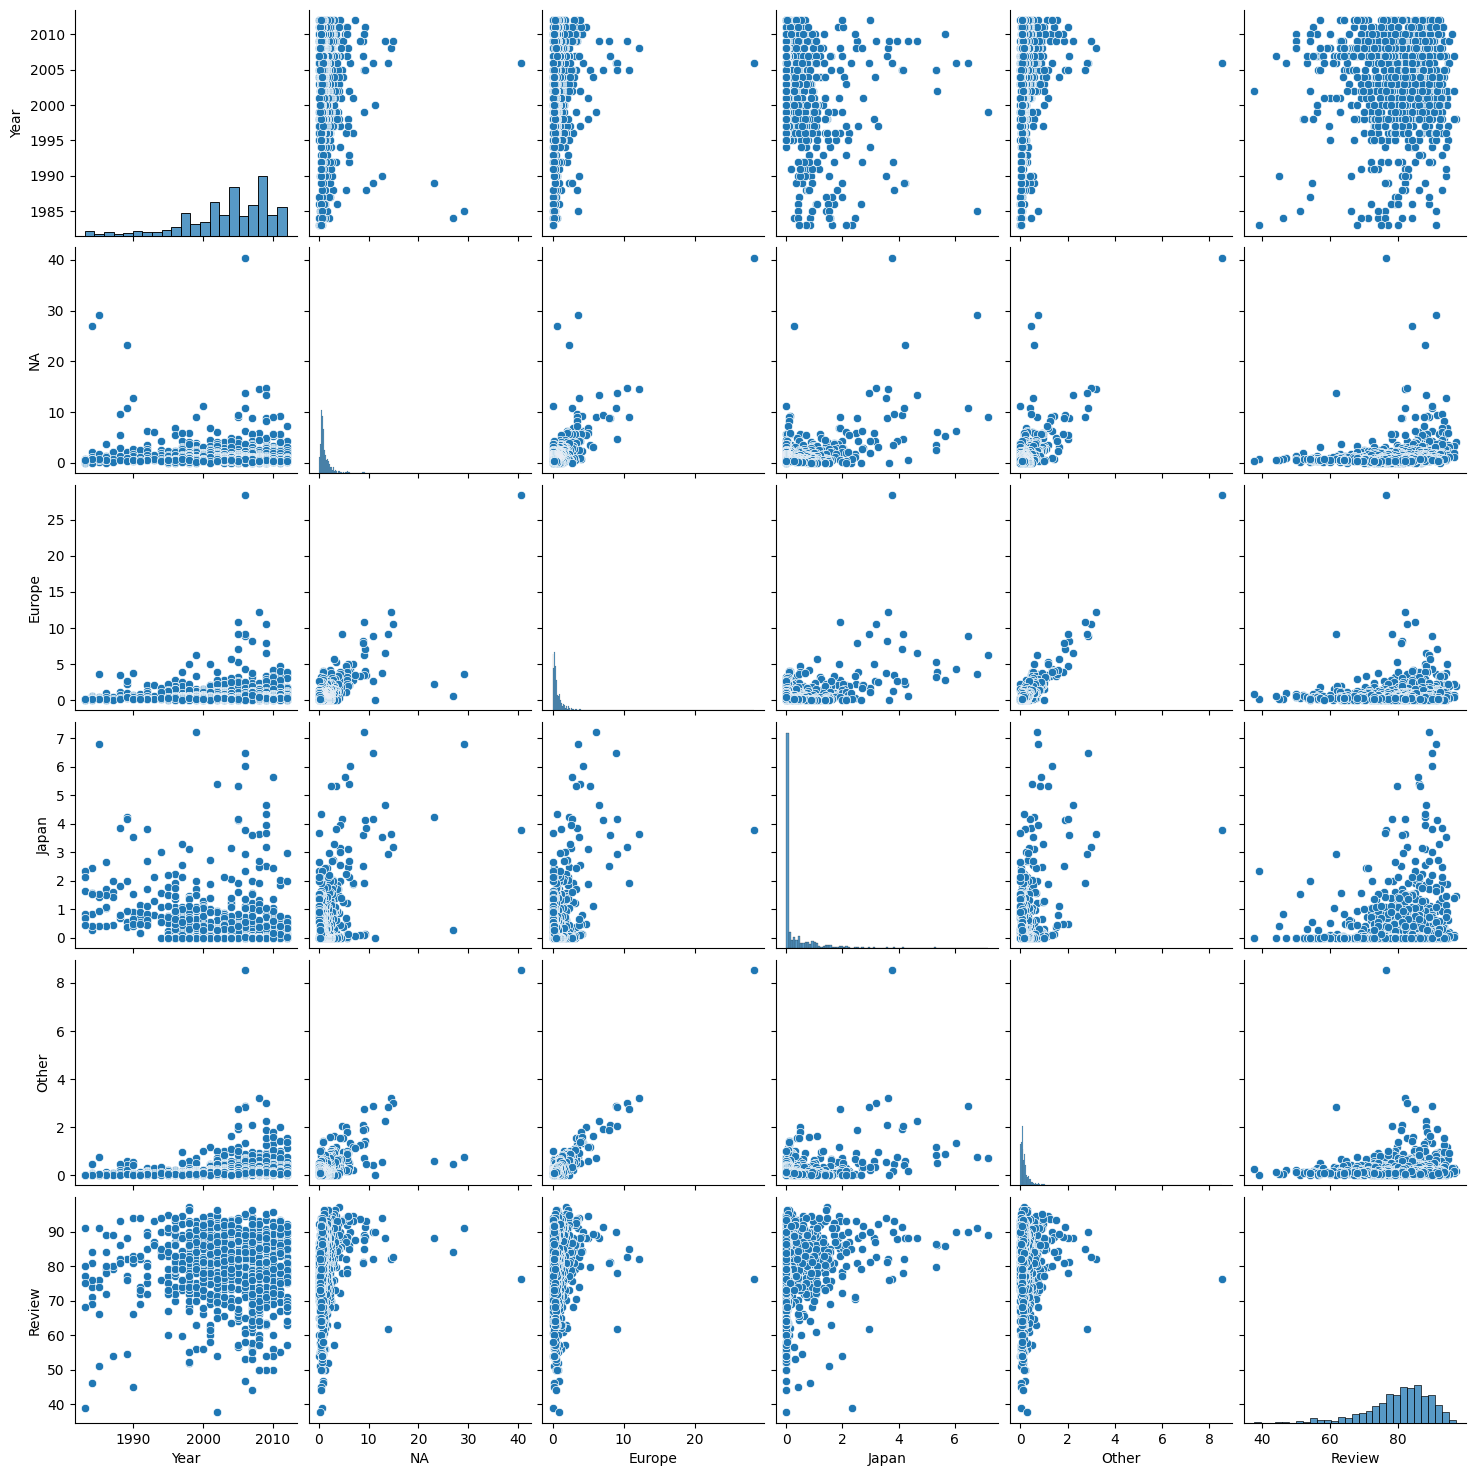

In [13]:
sns.pairplot(df_clean)

In [14]:
df_clean.corr()

,Year,NA,Europe,Japan,Other,Review
Year,1.000000,-0.105925,0.092960,-0.274782,0.198683,0.009427
NA,-0.105925,1.000000,0.728815,0.527007,0.696089,0.185197
Europe,0.092960,0.728815,1.000000,0.496411,0.936481,0.114512
Japan,-0.274782,0.527007,0.496411,1.000000,0.383147,0.140037
Other,0.198683,0.696089,0.936481,0.383147,1.000000,0.109299
Review,0.009427,0.185197,0.114512,0.140037,0.109299,1.000000


In [15]:
full_formula = 'NA~Year+Publisher+Europe+Japan+Other+Review'

In [16]:
full_model = smf.ols(formula=full_formula, data=df_clean).fit()

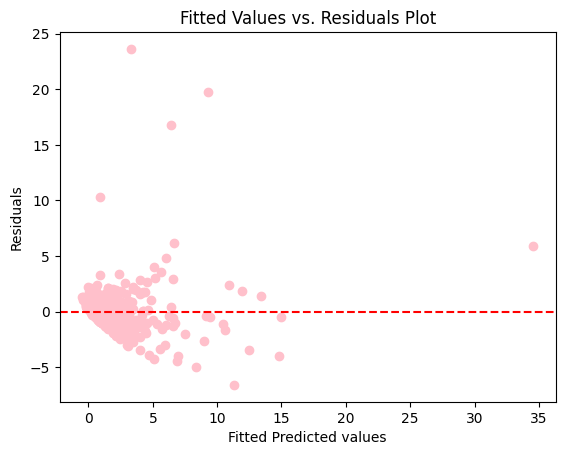

In [17]:
plt.scatter(full_model.fittedvalues, full_model.resid, color='pink')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Predicted values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs. Residuals Plot')
plt.show()

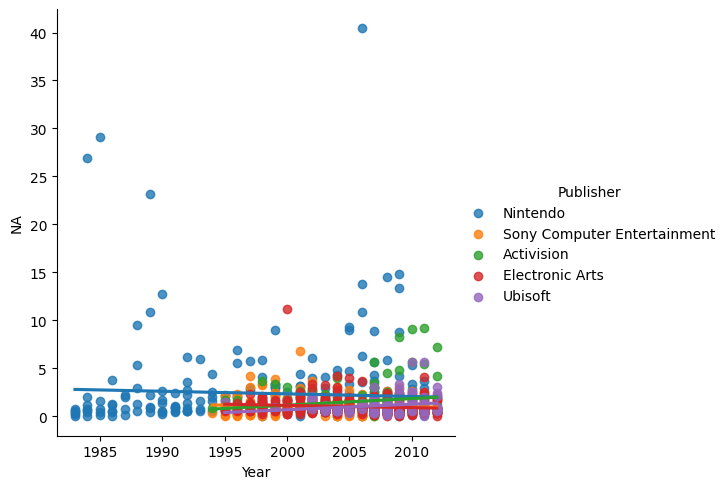

In [18]:
sns.lmplot(x='Year', y='NA', hue='Publisher',  ci=False, data=df_clean)

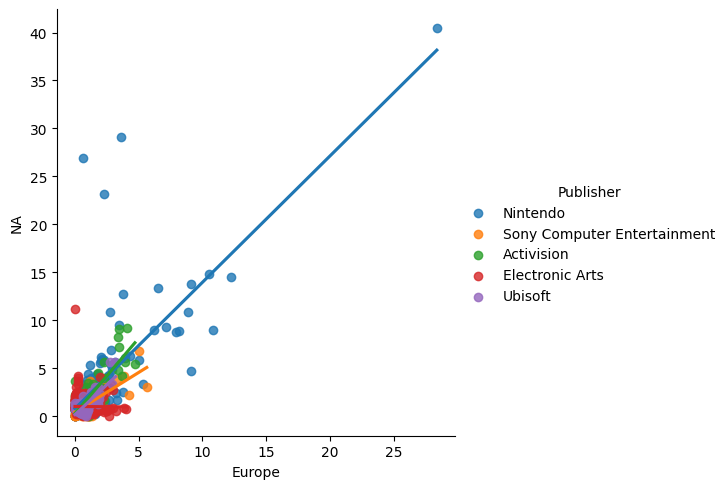

In [19]:
sns.lmplot(x='Europe', y='NA', hue='Publisher',  ci=False, data=df_clean)

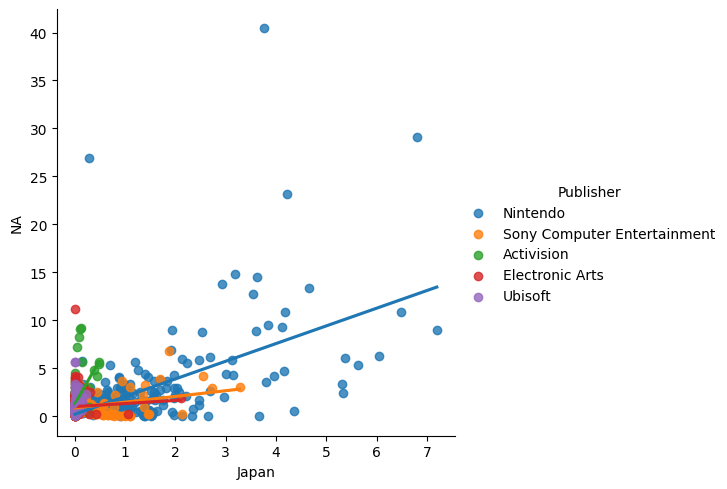

In [20]:
sns.lmplot(x='Japan', y='NA', hue='Publisher',  ci=False, data=df_clean)

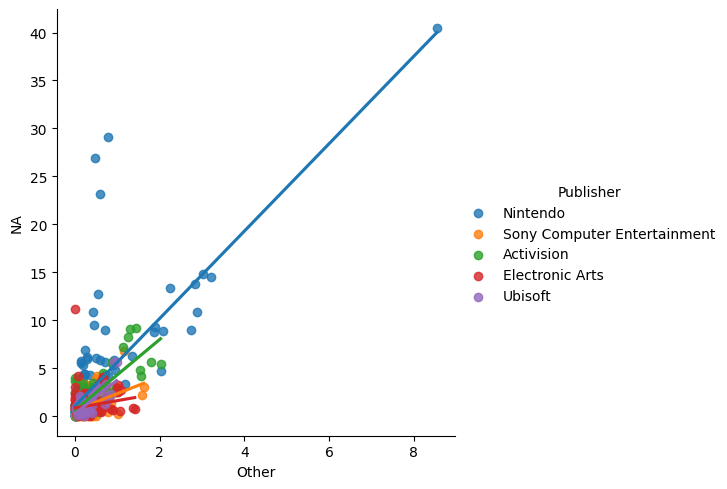

In [21]:
sns.lmplot(x='Other', y='NA', hue='Publisher',  ci=False, data=df_clean)

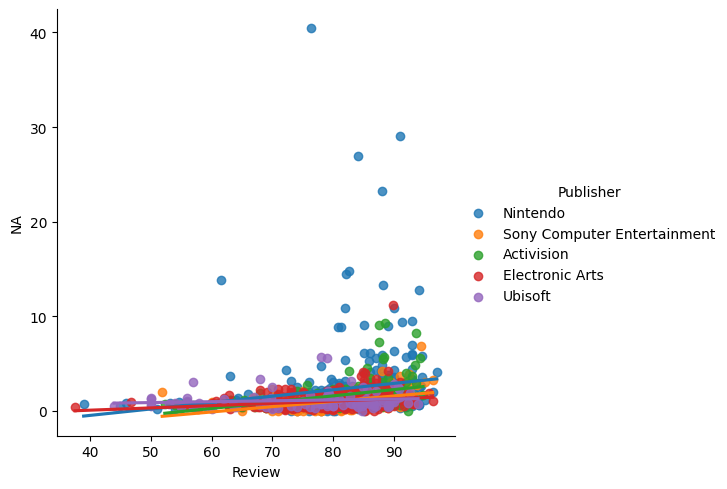

In [22]:
sns.lmplot(x='Review', y='NA', hue='Publisher',  ci=False, data=df_clean)

## 5. Predictive Models

To start off with, before creating the predictive models, the publisher variable was changed into indicator explanatory varaibles because I planned to use regularization to find the best predictive model. The explanatory variables that are being used for these models are the year, sales in Europe/Japan/Rest of the World, review score, and the publisher. The cleaned dataset was split into training and test datasets, with the test dataset containing 20% of the cleaned dataset's rows in order to test the regression models trained on the remaining 80% against. The test R^2 value for the non-regularized linear regression full model was 0.2544. I introduced interaction terms into the next non-regularized full model because publisher and review score showed that they had an impact on the sales in North America. The test R^2 for this model with interaction terms was greater than the one without as it ended up being 0.2648. I used LASSO regularization to find the model with the highest test R^2 because, when compared with RIDGE and elastic net, LASSO is the easiest to interpret as it sets all slopes that do not bring enough predictive power to the dataset equal to 0. This means that LASSO is not as realistic of a model as Ridge or elastic, but it suits the purposes for this analysis due to the ease of slope interpretation. When finding the test R^2 for LASSO models with different lambda values, the model with a lambda of 0 ended up having the highest value. Because the lambda was equal to 0, that means that all of the explanatory variables "bring enough" predictive power to the equation to be included. To summarize, the linear regression model with the highest predictive power for the test and potentially future datasets is the full model that includes interaction terms between publisher and reviews.

In [23]:
df_clean = pd.get_dummies(df_clean, drop_first=True)
df_clean.head()

,Year,NA,Europe,Japan,Other,Review,Publisher_Electronic Arts,Publisher_Nintendo,Publisher_Sony Computer Entertainment,Publisher_Ubisoft
0,2006.0,40.43,28.39,3.77,8.54,76.28,0,1,0,0
1,1985.0,29.08,3.58,6.81,0.77,91.00,0,1,0,0
2,2008.0,14.50,12.22,3.63,3.21,82.07,0,1,0,0
3,2009.0,14.82,10.51,3.18,3.01,82.65,0,1,0,0
4,1989.0,23.20,2.26,4.22,0.58,88.00,0,1,0,0


In [24]:
df_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=123)
df_test.shape[0] / df_clean.shape[0]

0.20058708414872797

In [25]:
x_train = df_train.drop(['NA'], axis=1)
x_test = df_test.drop(['NA'], axis=1)

y_train = df_train['NA']
y_test = df_test['NA']

In [26]:
scaler_training = StandardScaler()
scaled_expl_vars = scaler_training.fit_transform(x_train)

x_train = pd.DataFrame(scaled_expl_vars, columns=x_train.columns)
x_train.head()

,Year,Europe,Japan,Other,Review,Publisher_Electronic Arts,Publisher_Nintendo,Publisher_Sony Computer Entertainment,Publisher_Ubisoft
0,0.885281,-0.217826,-0.454222,0.037283,0.134953,-0.72013,-0.641135,2.445998,-0.317928
1,0.719506,0.085800,-0.454222,0.236367,-0.004252,-0.72013,-0.641135,-0.408831,-0.317928
2,1.382605,0.163322,3.029124,0.214247,0.138215,-0.72013,1.559735,-0.408831,-0.317928
3,0.553732,0.454028,0.777264,0.236367,-2.070568,-0.72013,1.559735,-0.408831,-0.317928
4,-0.606690,-0.282427,-0.454222,-0.471489,0.865776,-0.72013,-0.641135,-0.408831,-0.317928


In [27]:
scaled_expl_vars = scaler_training.transform(x_test)

x_test = pd.DataFrame(scaled_expl_vars, columns=x_test.columns)
x_test.head()

,Year,Europe,Japan,Other,Review,Publisher_Electronic Arts,Publisher_Nintendo,Publisher_Sony Computer Entertainment,Publisher_Ubisoft
0,0.222183,-0.527912,0.050101,-0.383007,0.865776,-0.720130,1.559735,-0.408831,-0.317928
1,-0.772465,-0.256586,0.003187,-0.316645,0.974530,-0.720130,-0.641135,2.445998,-0.317928
2,0.222183,-0.140304,-0.454222,0.214247,-0.737250,-0.720130,-0.641135,2.445998,-0.317928
3,0.719506,-0.204905,-0.430765,0.037283,0.841850,1.388638,-0.641135,-0.408831,-0.317928
4,-1.269789,-0.489151,0.319855,-0.405127,0.301346,-0.720130,-0.641135,2.445998,-0.317928


In [28]:
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(x_train, y_train)

lin_reg_mod.score(x_test, y_test)

0.25442583469672575

In [29]:
x_test['Publisher_Electronic Arts*Review'] = x_test['Review'] * x_test['Publisher_Electronic Arts']
x_test['Publisher_Nintendo*Review'] = x_test['Review'] * x_test['Publisher_Nintendo']
x_test['Publisher_Sony Computer Entertainment*Review'] = x_test['Review'] * x_test['Publisher_Sony Computer Entertainment']
x_test['Publisher_Ubisoft*Review'] = x_test['Review'] * x_test['Publisher_Ubisoft']

x_train['Publisher_Electronic Arts*Review'] = x_train['Review'] * x_train['Publisher_Electronic Arts']
x_train['Publisher_Nintendo*Review'] = x_train['Review'] * x_train['Publisher_Nintendo']
x_train['Publisher_Sony Computer Entertainment*Review'] = x_train['Review'] * x_train['Publisher_Sony Computer Entertainment']
x_train['Publisher_Ubisoft*Review'] = x_train['Review'] * x_train['Publisher_Ubisoft']

In [35]:
lin_reg_mod1 = LinearRegression()
lin_reg_mod1.fit(x_train, y_train)

lin_reg_mod1.score(x_test, y_test)

0.26478524794645

In [31]:
list = []
mod_list = []

for i in np.arange(0,0.5005,0.005):
    lasso_mod_i = Lasso(alpha=i, max_iter=1000)
    mod_list.append(lasso_mod_i)
    lasso_mod_i.fit = lasso_mod_i.fit(x_train, y_train)
    list.append([i, lasso_mod_i.score(x_test, y_test)])

df_output = pd.DataFrame(list, columns=['Lambda', 'Test R^2'])
df_output.sort_values(by='Test R^2', ascending=False)

C:\Users\annab\AppData\Local\Temp\ipykernel_33620\2947409967.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_mod_i.fit = lasso_mod_i.fit(x_train, y_train)
c:\Users\annab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\annab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.029e+02, tolerance: 4.584e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.

,Lambda,Test R^2
0,0.000,0.264785
1,0.005,0.263120
2,0.010,0.261171
3,0.015,0.258912
4,0.020,0.256356
...,...,...
96,0.480,0.153641
97,0.485,0.152887
98,0.490,0.152122
99,0.495,0.151355


Text(0, 0.5, 'R^2')

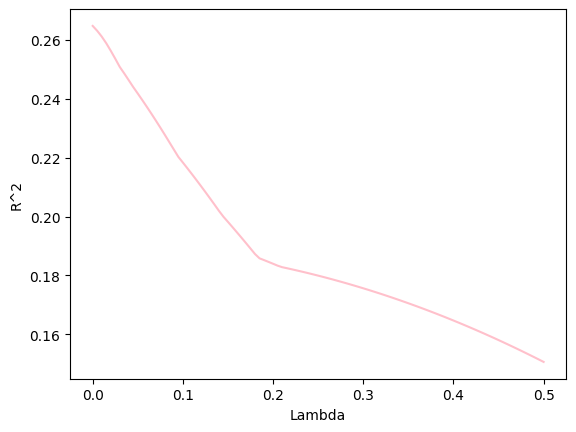

In [32]:
plt.plot(df_output['Lambda'].values, df_output['Test R^2'].values, color='pink')
plt.xlabel('Lambda')
plt.ylabel('R^2')

## 6. Best Model Discussion

^<br>
NA = 	
            
            -0.297402 (Year)

            +0.863300 (Europe)

            +0.512759 (Japan)

            +0.897894 (Other)

            +0.213972 (Review)

            -0.175553 (Publisher[T.Electronic Arts])

            -0.282841 (Publisher[T.Nintendo])

            -0.295883 (Publisher[T.Sony Computer Entertainment])

            -0.098573 (Publisher[T.Ubisoft])

            -0.055324 (Publisher[T.Electronic Arts]*Review)

            +0.067518 (Publisher[T.Nintendo]*Review)

            -0.034055(Publisher[T.Sony Computer Entertainment]*Review)
            
            -0.078456(Publisher[T.Ubisoft]*Review)

The overall fit of the best model for the test dataset is not the best as it only represents around 26.5% of the North American sales, a larger test R^2 value would have been a better fit. The best model does not suggest that some of the original explanatory variables were overfitting the model because no slopes were set equal to 0 for that model. Yes, these remaining explanatory variables in this model exhibit an issue with multicollinearity because no variables were excluded from the final model, so there is still that strong relationship between Other (sales in the rest of the world) and Europe. Yes, I am able to interpret the magnitudes of these slopes as indicating the importance of that explanatory variable when predicting the response variable because all of the explanatory variables have been scaled to their z-scores. The sales in Europe, the rest of the world, and Japan brought the most predictive power to the model respectively because they had the largest slopes in the model. 

In [33]:
df_slope = pd.DataFrame({'lasso_mod': mod_list[0].coef_.T}, index=x_train.columns)
df_slope

,lasso_mod
Year,-0.297402
Europe,0.863300
Japan,0.512759
Other,0.897894
Review,0.213972
Publisher_Electronic Arts,-0.175553
Publisher_Nintendo,-0.282841
Publisher_Sony Computer Entertainment,-0.295883
Publisher_Ubisoft,-0.098573
Publisher_Electronic Arts*Review,-0.055324


## 7. Conclusion

I would not recommend my best model to be used by producers or retailers of video games because it only represents about 1/4 of the test dataset, meaning it would roughly represent the same amount of North American sales for new datasets. I do not know for sure that my chosen best model will yield the highest possible test R^2 out of all possible models because I only used LASSO regularization. Possibly, a better model could be found by using an elastic net model to make a more complete analysis. Additionally, a complete analysis could also experiment with using forwards or backwards elimination methods to find the "best" model this dataset could produce. One shortcoming of my analysis is that not all of the publishers were included in the final model, only the top publishers remained. If a company made it to those top 5 represented in the model, they definitely have their own forecasting department and would not need a basic regression model such as the one made for this report. An idea I'd like to explore in the future is predicting the review score of a video game. Experiences of a game can be subjective, but I'd like to see what factors have the greatest impact of someone's enjoyment of a game.